Import libraries and clean 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns # tSNE visualization

In [2]:
df = pd.read_csv('data/Seasons_Stats.csv')
print(df.shape)

(24691, 53)


In [3]:
def filter_years(df):
    # Filter data so only seasons from 2010 onwards are included
    df = df[df['Year'].notna()]
    df = df[df['Year'] >= 2010]
    df['Year'] = df['Year'].astype(int)
    return df

def cleaned_df(df):
    # Clean dataframe so only 1 season stat is included for every player per season
    years = df['Year'].unique()
    for year in years:
        df_year = df[df['Year'] == year]
        df_year = df_year[df_year.duplicated(subset='Player', keep=False)]
        common_rows = df['Unnamed: 0'].isin(df_year['Unnamed: 0'])
        df.drop(df[common_rows].index, inplace = True)
        df = df.append(df_year[df_year['Tm'] == 'TOT'])
    return df

def fill_empty_values(df):
    # Remove unneccesary columns and fill nulls with 0
    df.drop(columns=['Unnamed: 0', 'blanl', 'blank2'], inplace=True)
    df.drop(df[df['USG%'].isnull()].index, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [4]:
df = filter_years(df)
df = cleaned_df(df)
df = fill_empty_values(df)
df.shape

(3771, 50)

In [5]:
# Taking only first position listed when multiple are listed
df['Pos'] = df['Pos'].str.split('-').str[0]

Visualize

I. PCA

In [6]:
features = [x for x in df.columns if (x != 'Player') &  (x != 'Pos')]
print(df.shape)
print(features)

(3771, 50)
['Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [7]:
def plot_PCA(df, year):
    df_vis = df[df['Year'] == year]
    df_vis = df_vis.drop('Year', axis=1)
    features = [x for x in df_vis.columns if (x != 'Player') &  (x != 'Pos') & (x != 'Tm')]
    x = df_vis.loc[:, features].values
    y = df_vis.loc[:,['Pos']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    final = pd.concat([principalDf.reset_index(drop=True), df_vis['Pos'].reset_index(drop=True)], axis=1)
    print("Explained variance: ", pca.explained_variance_ratio_)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = final.Pos.unique() # list of positions (PCA groups)
    colors = ['r', 'g', 'b', 'm', 'c']
    for target, color in zip(targets,colors):
        indicesToKeep = final['Pos'] == target
        ax.scatter(final.loc[indicesToKeep, 'pc1']
                , final.loc[indicesToKeep, 'pc2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()
    return final,pca,features

def plot_featImport_PCA(pcaObj, features):
     # feature importance for first dimension
    fimp1 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[0]})
    fimp1 = fimp1.reindex(fimp1.imp.abs().sort_values(ascending = False).index)
    # print(fimp1)
    top_fimp1 = fimp1.nlargest(10,'imp')
    top_fimp1 = top_fimp1.iloc[::-1]
    top_fimp1 = top_fimp1.set_index("feat")
    ax = top_fimp1.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 1 Feature Importance', fontsize = 20)

    # repeat for second dimension
    fimp2 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[1]})
    fimp2 = fimp2.reindex(fimp2.imp.abs().sort_values(ascending = False).index)
    top_fimp2 = fimp2.nlargest(10,'imp')
    top_fimp2 = top_fimp2.iloc[::-1]
    top_fimp2 = top_fimp2.set_index("feat")
    ax = top_fimp2.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 2 Feature Importance', fontsize = 20)

Explained variance:  [0.43195393 0.16785902]


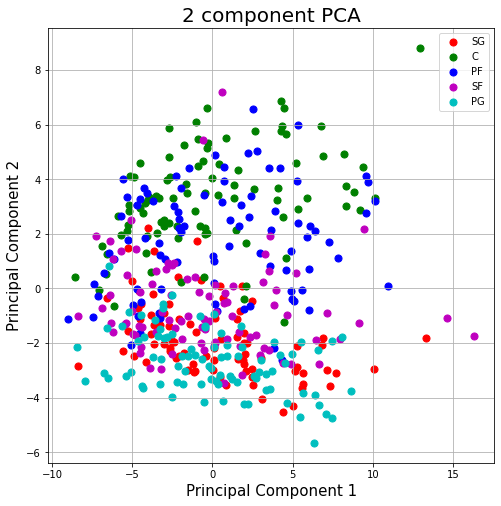

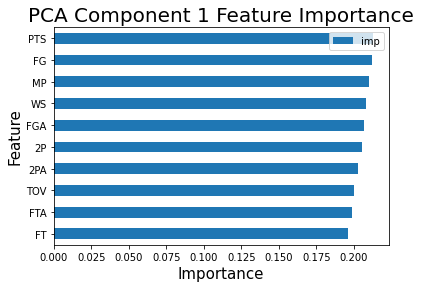

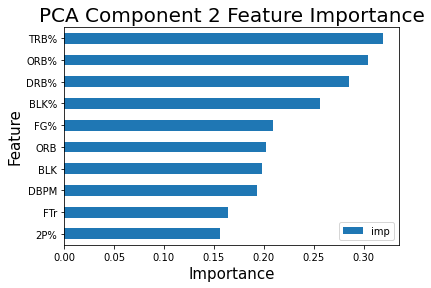

In [8]:
df_PCA, pca, features = plot_PCA(df, 2010)
# print(df_PCA.head)
plot_featImport_PCA(pca, features)

II. t-SNE

In [16]:


def plot_tSNE(df, year, perplexity): # perplexity is list 

    df_tSNE = df[df['Year'] == year]
    df_tSNE = df_tSNE.drop('Year', axis=1)
    features = [x for x in df_tSNE.columns if (x != 'Player') &  (x != 'Pos') & (x != 'Tm')]
    x = df_tSNE.loc[:, features].values
    y = df_tSNE.loc[:,['Pos']].values
    tSNE_data = StandardScaler().fit_transform(x)

    for p in perplexity:
        tSNE_embed = TSNE(n_components=2, perplexity=p, random_state=0).fit_transform(x) # perplexity arg of TSNE can be modified (default=30)
        tsne_results = pd.DataFrame(data = tSNE_embed, columns = ['t1', 't2'])
        tsne_final = pd.concat([tsne_results.reset_index(drop=True), df_tSNE['Pos'].reset_index(drop=True)], axis=1)
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style("ticks")
        sns.lmplot(x='t1',
                y='t2',
                data=tsne_final,
                fit_reg=False,
                legend=True,
                height=9,
                hue='Pos',
                scatter_kws={"s":200, "alpha":0.3})
        
        plt.title('Perplexity = '+ str(p)).set_fontsize('14')
        plt.xlabel('T 1', weight='bold').set_fontsize('10')
        plt.ylabel('T 2', weight='bold').set_fontsize('10')
    return None

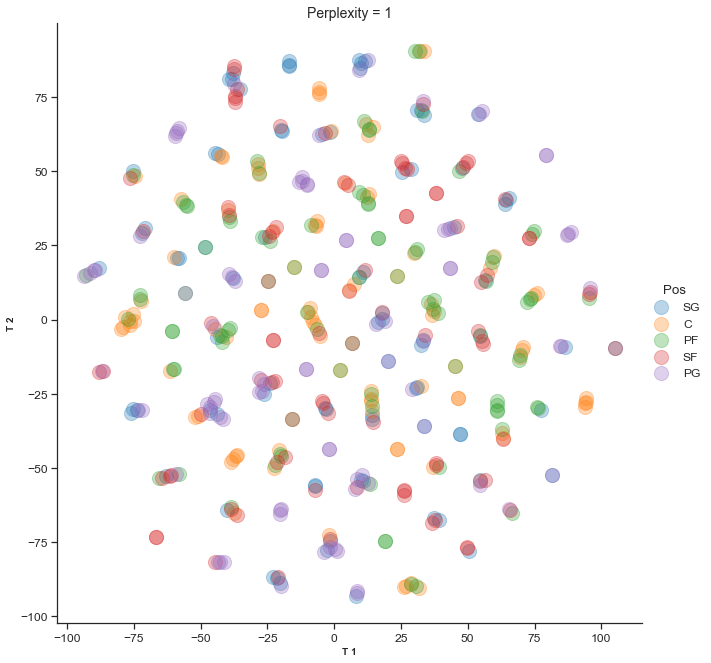

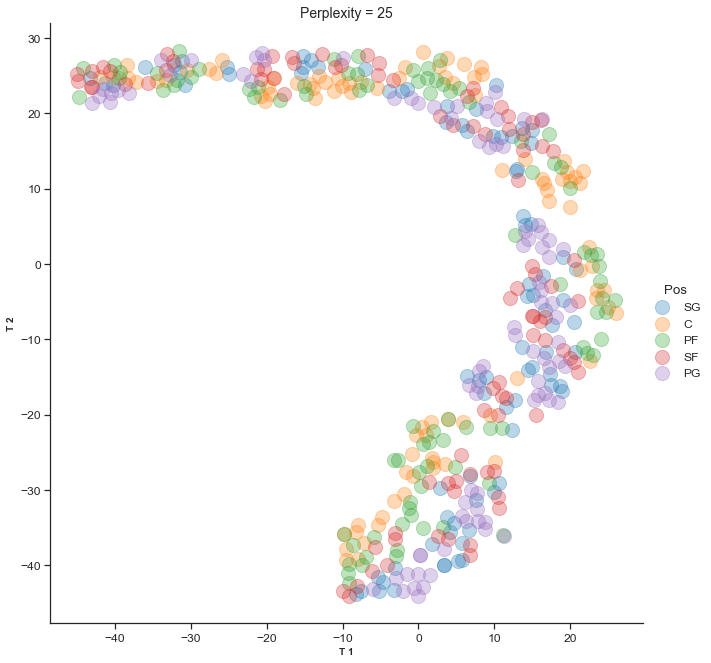

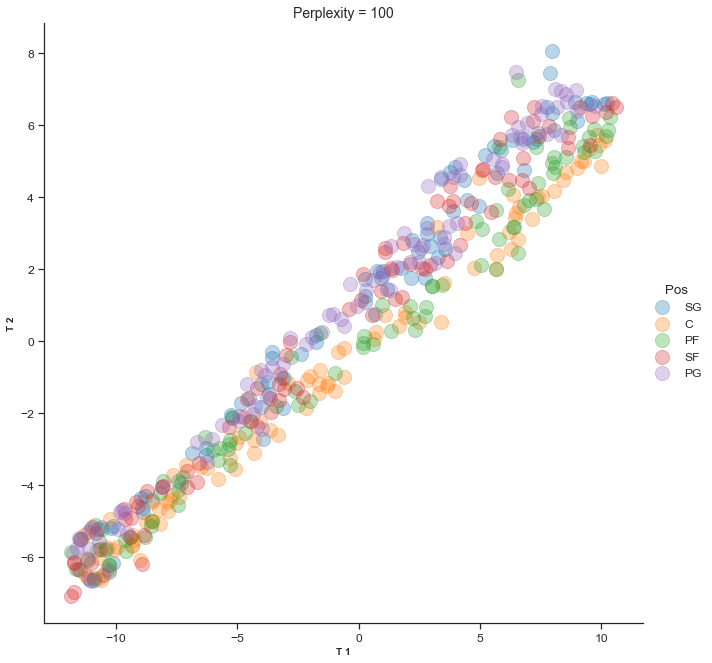

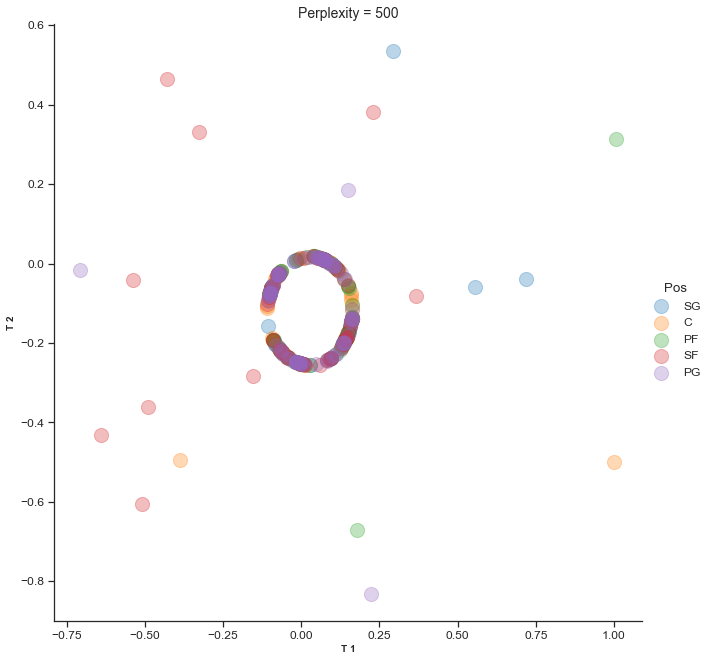

In [17]:
plot_tSNE(df, 2010, [1, 25, 100, 500])